In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.max_columns',None)

In [2]:
open_nonsenior = pd.read_csv('Data/open_cases_nonsenior_04262022.csv')
open_nonsenior['Development'] = open_nonsenior['Development'].apply(lambda x: str(x).strip())

closed_nonsenior = pd.read_csv('Data/closed_cases_nonsenior_04262022.csv')
closed_nonsenior['Development'] = closed_nonsenior['Development'].apply(lambda x: str(x).strip())

all_nonsenior = open_nonsenior.append(closed_nonsenior)

open_senior = pd.read_csv('Data/open_cases_senior_04252022.csv')
open_senior['Development'] = open_senior['Development'].apply(lambda x: str(x).strip())

closed_senior = pd.read_csv('Data/closed_senior_04302022.csv')
closed_senior['Development'] = closed_senior['Development'].apply(lambda x: str(x).strip())

all_senior = open_senior.append(closed_senior)

rejected = pd.read_csv('Data/rejected_06142022.csv')
rejected['Development'] = rejected['Development'].apply(lambda x: str(x).strip())

/tmp/ipykernel_196457/1452330495.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_nonsenior = open_nonsenior.append(closed_nonsenior)
/tmp/ipykernel_196457/1452330495.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_senior = open_senior.append(closed_senior)


In [3]:
nycha_org_dim = pd.read_csv('Data/dev_data/nycha_org_dim.csv')
pop_facts = pd.read_csv('Data/dev_data/pop_facts.csv')

nycha_org_dim['SENIOR_DEV_IND'] = nycha_org_dim['SENIOR_DEV_IND'].apply(lambda x: 1 if x == 'Y' else 0)

def combine_records(search_term, search_field, combined_dev_name, df, new_cons_name = None):
    rel_rows = df[df[search_field].apply(lambda x: search_term in str(x).upper())]
    
    cons_tds = rel_rows.iloc[0]['CONSOLIDATED_TDS_NUM']
    if new_cons_name == None:
        consolidated_name = rel_rows.iloc[0]['CONSOLIDATED_NAME']
    else:
        consolidated_name = new_cons_name
    borough_name = rel_rows.iloc[0]['BOROUGH_NAME']
    senior_dev_ind = max(rel_rows['SENIOR_DEV_IND'])
    deputy_director = rel_rows.iloc[0]['DEPUTY_DIRECTOR']
    
    combined_row = pd.DataFrame(rel_rows.sum()).transpose()
    combined_row['CONSOLIDATED_TDS_NUM'] = cons_tds
    combined_row['CONSOLIDATED_NAME'] = consolidated_name
    combined_row['TDS_NUM'] = None
    combined_row['DEVELOPMENT_NAME'] = combined_dev_name
    combined_row['BOROUGH_NAME'] = borough_name
    combined_row['SENIOR_DEV_IND'] = senior_dev_ind
    combined_row['DEPUTY_DIRECTOR'] = deputy_director
    
    combined_row['PERCENTAGE_ELDERLY'] = (combined_row['ELDERLY_POP']/combined_row['TOTAL_POP'])*100
    
    return combined_row

In [4]:
pop_facts_enriched = nycha_org_dim[['CONSOLIDATED_TDS_NUM','TDS_NUM','CONSOLIDATED_NAME','DEVELOPMENT_NAME','BOROUGH_NAME', 'SENIOR_DEV_IND','DEPUTY_DIRECTOR']].merge(pop_facts, how='outer', on='TDS_NUM')

combined_consolidations = pd.DataFrame(columns = ('CONSOLIDATED_TDS_NUM','TDS_NUM','CONSOLIDATED_NAME','DEVELOPMENT_NAME', 'NUM_BLDG','OCCUPIED_APT', 'VACANT_AVAILABLE_APT','TOTAL_POP','ELDERLY_POP','PERCENTAGE_ELDERLY','MOBILITY_IMPAIRED'))

for dev_term, dev_name in [('RIIS', 'RIIS -- COMBINED'), ('MORRIS', 'MORRIS -- COMBINED'), ('FHA', 'FHA REPOSSESSED HOUSES -- ALL GROUPS')]:
    combined_consolidations = combined_consolidations.append(combine_records(dev_term, 'DEVELOPMENT_NAME', dev_name, pop_facts_enriched))

for cons_term, dev_name in [('KRAUS','KRAUS PROPERTIES'), ('BUILDING MANAGEMENT ASSOCIATES', 'BMA PROPERTIES')]:
    combined_consolidations = combined_consolidations.append(combine_records(cons_term, 'CONSOLIDATED_NAME', dev_name, pop_facts_enriched, new_cons_name = dev_name))

pop_facts_enriched = pop_facts_enriched.append(combined_consolidations)
pop_facts_enriched['CONSOLIDATED_NAME'] = pop_facts_enriched['CONSOLIDATED_NAME'].apply(lambda x: combine_kraus(x))
pop_facts_enriched['TOTAL_POP'] = pop_facts_enriched['TOTAL_POP'].fillna(-999)

/tmp/ipykernel_196457/1975619037.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_consolidations = combined_consolidations.append(combine_records(dev_term, 'DEVELOPMENT_NAME', dev_name, pop_facts_enriched))
/tmp/ipykernel_196457/1975619037.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_consolidations = combined_consolidations.append(combine_records(dev_term, 'DEVELOPMENT_NAME', dev_name, pop_facts_enriched))
/tmp/ipykernel_196457/1975619037.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_consolidations = combined_consolidations.append(combine_records(dev_term, 'DEVELOPMENT_NAME', dev_name, pop_facts_enriched))
/tmp/ipykernel_196457/1975619037.py:9: FutureWarning: The frame.append metho

NameError: name 'combine_kraus' is not defined

In [5]:
#Note -- the two Murphy developments are Kraus Management properties, and are, in effect, dropped

alt_dev_names = {'DREW HAMILTON':'DREW-HAMILTON',
                 'UPACA SITE 6':'UPACA (SITE 6)',
                 'RIIS FEDERAL':'RIIS -- COMBINED',
                 'LOWER EAST SIDE INFILL #1':'LOWER EAST SIDE I INFILL',
                'UNITY PLAZA':'UNITY PLAZA (SITES 4-27)',
                'HOLMES':'HOLMES TOWERS',
                'NEW LANE SHORES':'NEW LANE AREA',
                'DE HOSTOS':'DE HOSTOS APARTMENTS',
                'LAFAYETTE GARDENS':'LAFAYETTE',
                'OCEAN HILL':'OCEAN HILL APARTMENTS',
                'FHA REPOSSESSED HOUSES GP I':'FHA REPOSSESSED HOUSES -- ALL GROUPS',
                'UNITY PLAZA - TURNKEY': 'UNITY PLAZA (SITES 17,24,25A)',
                'BAYVIEW':'BAY VIEW',
                'ATLANTIC TERMINAL':'ATLANTIC TERMINAL SITE 4B',
                'SITES 4 AND 5, CONEY ISLAND I': 'CONEY ISLAND I (SITES 4 & 5)',
                'BAILEY AVE-WEST 193 STREET':'BAILEY AVENUE-WEST 193RD STREET',
                'JUSTICE SONIA SOTOMAYOR':'SOTOMAYOR',
                'LAGUARDIA ADDITION':'LA GUARDIA ADDITION', 
                 'WSUR VEST POCKETS':'WSUR (BROWNSTONES)', 
                 'SACK-WERN':'SACK WERN',
                 'TWIN PARKS EAST':'TWIN PARKS EAST (SITE 9)', 
                 'PARK ROCK CONSOLIDATED':'PARK ROCK REHAB', 
                 'LONG ISLAND BAPTIST':'LONG ISLAND BAPTIST HOUSES',
                 'REVEREND BROWN':'BROWN', 
                 'MARCUS GARVEY':'GARVEY (GROUP A)', 
                 'VANDALIA':'VANDALIA AVENUE', 
                 '2125 GLEBE AVE.':'GLEBE AVENUE-WESTCHESTER AVENUE',
                 '1162 WASHINGTON AVE.':'1162-1176 WASHINGTON AVENUE', 
                 'TODT HILL HOUSE':'TODT HILL', 
                 'WEST TREMONT-SEDGWICK':'WEST TREMONT AVENUE-SEDGWICK AVENUE',
                 'TAYLOR WYTHE':'TAYLOR STREET-WYTHE AVENUE', 
                 'MELTZER':'MELTZER TOWER', 
                 '1100 TELLER AVE.':'TELLER AVENUE-EAST 166TH STREET', 
                 'MORRIS':'MORRIS -- COMBINED',
                 'EASTCHESTER':'EASTCHESTER GARDENS', 
                 'KINGSBOROUGH EXT.':'KINGSBOROUGH EXTENSION', 
                 'MC KINLEY':'MCKINLEY',
                 'CLAREMONT REHAB II':'CLAREMONT REHAB (GROUP 2)', 
                 'CLAREMONT REHAB V':'CLAREMONT REHAB (GROUP 5)',
                 'EAST NY CITY LINE SCATTERED SITES':'EAST NEW YORK CITY LINE', 
                 'FREDERICK E. SAMUEL APTS.':'SAMUEL (CITY)',
                 'BMA/MURPHY PRIVATE':'BMA PROPERTIES', 
                 'MURPHY PRIVATE':'KRAUS PROPERTIES', 
                 'CLAREMONT REHAB III':'CLAREMONT REHAB (GROUP 3)',
                 'DOUGLASS REHAB':'REHAB PROGRAM (DOUGLASS REHABS)', 
                 'LANGSTON HUGHES':'HUGHES APARTMENTS', 
                 'FORT INDEPENDENCE':'FORT INDEPENDENCE STREET-HEATH AVENUE',
                 '131 ST. NICHOLAS AVE':'131 SAINT NICHOLAS AVENUE',
                 '1471 WATSON AVE.':'1471 WATSON AVENUE',
                 '33-35 SARATOGA AVENUE':'SARATOGA VILLAGE',
                 '830 AMSTERDAM AVE':'830 AMSTERDAM AVENUE',
                 '905-907 EAGLE AVE.':'EAGLE AVENUE-EAST 163RD STREET',
                 'AUDUBON APARTMENTS':'AUDUBON',
                 'BARUCH ADDITION':'BARUCH HOUSES ADDITION',
                 'BEDFORD STUYVESANT REHAB PHASE I':'BEDFORD-STUYVESANT REHAB',
                 'BERRY HOUSES':'BERRY',
                 'BOSTON-SECOR':'BOSTON SECOR',
                 'BOYNTON AVENUE REHABS':'BOYNTON AVENUE REHAB',
                 'CLAREMONT REHAB IV':'CLAREMONT REHAB (GROUP 4)',
                 'COLLEGE AVE-E.165 ST':'COLLEGE AVENUE-EAST 165TH STREET',
                 'COLLEGE POINT REHAB PROGRAM':'REHAB PROGRAM (COLLEGE POINT)',
                 'CONEY ISLAND CDA, 1B': 'CONEY ISLAND I (SITE 1B)',
                 'CONEY ISLAND CDA, 8':'CONEY ISLAND I (SITE 8)',
                 'CONLON-LIHFE TOWERS':'CONLON LIHFE TOWERS',
                 'CORSI':'CORSI HOUSES',
                 'CROWN HEIGHTS REHABS':'CROWN HEIGHTS',
                 'DOME SITE':'154 WEST 84TH STREET',
                 'DOUGLASS': 'DOUGLASS I',
                 'EAST 180 STREET & MONTEREY AVENUE':'EAST 180TH STREET-MONTEREY AVENUE',
                 'HARRISON AVENUE REHABS. GROUP A':'HARRISON AVENUE REHAB (GROUP A)',
                 'HOWARD PARK':'HOWARD AVENUE-PARK PLACE',
                 'JACKIE ROBINSON':'ROBINSON',
                 'LAGUARDIA': 'LA GUARDIA',
                 'LEAVITT ST. 34TH AVE':'LEAVITT STREET-34TH AVENUE',
                 'LEHMAN VILLAGE':'LEHMAN',
                 'LENOX ROAD REHABS':'LENOX ROAD-ROCKAWAY PARKWAY',
                 'LOWER EAST SIDE GRP5':'LOWER EAST SIDE REHAB (GROUP 5)',
                 'MACOMBS ROAD REHAB.':'MACOMBS ROAD',
                 'MORRIS HEIGHTS REHAB.':'MORRIS HEIGHTS REHAB',
                 'MURPHY PRIVATE': 'KRAUS PROPERTIES',
                 'OCEAN HILL BROWNSVILLE':'OCEAN HILL-BROWNSVILLE',
                 'RALPH AVENUE REHABS':'RALPH AVENUE REHAB',
                 'RANDALL BALCOM':'RANDALL AVENUE-BALCOM AVENUE',
                 'REID':'REID APARTMENTS',
                 'RIIS CITY':'RIIS -- COMBINED',
                 'SAINT JOHNS - STERLING PLACE':'STERLING PLACE REHABS (SAINT JOHNS-STERLING)',
                 'SETH LOW':'LOW HOUSES',
                 'SHELTON HOUSES':'SHELTON HOUSE',
                 'SONDRA THOMAS APARTMENTS':'THOMAS APARTMENTS',
                 'SOUTH BRONX SITE 402':'SOUTH BRONX AREA (SITE 402)',
                 'STEBBINS HEWITT':'STEBBINS AVENUE-HEWITT PLACE',
                 'STERLING - BUFFALO':'STERLING PLACE REHABS (STERLING-BUFFALO)',
                 'SUTTER AVENUE - UNION STREET':'SUTTER AVENUE-UNION STREET',
                 'TAFT REHAB':'REHAB PROGRAM (TAFT REHABS)',
                 'TAPSCOTT ST REHAB':'TAPSCOTT STREET REHAB',
                 'THURGOOD MARSHALL PLAZA':'MARSHALL PLAZA',
                 'TWO BRIDGES':'TWO BRIDGES URA (SITE 7)',
                 'UNION AVENUE & EAST 163 STREET':'UNION AVENUE-EAST 163RD STREET',
                 'UNION AVENUE & EAST 166 STREET':'UNION AVENUE-EAST 166TH STREET',
                 'UNIVERSITY AVENUE REHAB.':'UNIVERSITY AVENUE REHAB',
                 'UPACA SITE 5':'UPACA (SITE 5)',
                 'VLADECK I':'VLADECK',
                 'WEST TREEMONT REHAB. GROUP 1':'WEST TREMONT REHAB (GROUP 1)',
                 'WEST TREEMONT REHAB. GROUP 2':'WEST TREMONT REHAB (GROUP 2)',
                 'WISE REHAB':'REHAB PROGRAM (WISE REHAB)',
                 'WSUR REHABS':'WSUR (SITE A) 120 WEST 94TH STREET',
                 'WSUR VP 589 AMSTERDAM AVE':'WSUR (SITE C) 589 AMSTERDAM AVENUE',
                 'WSUR VP 74 W. 92 ST':'WSUR (SITE B) 74 WEST 92ND STREET'}

standard_namelist = pop_facts_enriched['DEVELOPMENT_NAME'].to_list()

def match_dev_names(name, std_namelist, alt_namelist):
    try:
        if name in std_namelist:
            return name
        else:
            return alt_namelist[name]
    except:
        return None

all_nonsenior['_match_dev'] = all_nonsenior['Development'].apply(lambda x: match_dev_names(x, standard_namelist, alt_dev_names))
all_senior['_match_dev'] = all_senior['Development'].apply(lambda x: match_dev_names(x, standard_namelist, alt_dev_names))
rejected['_match_dev'] = rejected['Development'].apply(lambda x: match_dev_names(x, standard_namelist, alt_dev_names))

In [6]:
all_nonsenior['Ref_Date'] = pd.to_datetime(all_nonsenior['Ref_Date'])
all_nonsenior['REF_YEAR'] = all_nonsenior['Ref_Date'].apply(lambda x: x.date().year)
all_nonsenior['NAME'] = all_nonsenior['Last']+', '+all_nonsenior['First']+all_nonsenior['Acct']
all_nonsenior_recent = all_nonsenior[all_nonsenior['REF_YEAR'] >= 2017]


all_senior['Ref_Date'] = pd.to_datetime(all_senior['Ref_Date'])
all_senior['REF_YEAR'] = all_senior['Ref_Date'].apply(lambda x: x.date().year)
all_senior['NAME'] = all_senior['Last']+', '+all_senior['First']+all_senior['Acct']
all_senior_recent = all_senior[all_senior['REF_YEAR'] >= 2017]

rejected['Ref_Date'] = pd.to_datetime(rejected['Ref_Date'])
rejected['REF_YEAR'] = rejected['Ref_Date'].apply(lambda x: x.date().year)
rejected['NAME'] = rejected['Last']+', '+rejected['First']+rejected['Acct']
rejected_recent = rejected[rejected['REF_YEAR'] >= 2017]

all_referrals = all_nonsenior.append(all_senior).append(rejected)
all_recent = all_nonsenior_recent.append(all_senior_recent).append(rejected_recent)

#all_recent = all_nonsenior_recent

/tmp/ipykernel_196457/4069856691.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_referrals = all_nonsenior.append(all_senior).append(rejected)
/tmp/ipykernel_196457/4069856691.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_referrals = all_nonsenior.append(all_senior).append(rejected)
/tmp/ipykernel_196457/4069856691.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_recent = all_nonsenior_recent.append(all_senior_recent).append(rejected_recent)
/tmp/ipykernel_196457/4069856691.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_recent = all_nonsenior_recent.append(all_senior_recent).append(rejected_recent)


In [7]:
def reshape_recent_referrals(all_recent):
    recent_by_dev = all_recent.groupby('Development').agg({'_match_dev':'first','Case_ID':'count'}).reset_index()
    recent_by_dev = recent_by_dev.merge(pop_facts_enriched[pop_facts_enriched['TOTAL_POP'] != -999], left_on='_match_dev', right_on='DEVELOPMENT_NAME', how='outer', indicator=True)
    recent_by_dev['PER_RES'] = recent_by_dev['Case_ID']/recent_by_dev['TOTAL_POP']

    recent_by_year_by_dev = all_recent.groupby(['Development', 'REF_YEAR']).agg({'_match_dev':'first','Case_ID':'count'}).reset_index()
    recent_by_year_by_dev = recent_by_year_by_dev.merge(pop_facts_enriched[pop_facts_enriched['TOTAL_POP'] != -999], left_on='_match_dev', right_on='DEVELOPMENT_NAME', how='outer', indicator=True)
    recent_by_year_by_dev['PER_RES'] = recent_by_year_by_dev['Case_ID']/recent_by_year_by_dev['TOTAL_POP']

    pop_facts_by_cons = pop_facts_enriched[pop_facts_enriched['TOTAL_POP'] != -999].groupby('CONSOLIDATED_NAME').agg({'TOTAL_POP':sum, 'ELDERLY_POP':sum, 'BOROUGH_NAME':'first', 'SENIOR_DEV_IND':max, 'DEVELOPMENT_NAME':'count', 'CONSOLIDATED_TDS_NUM':'first'}).reset_index()

    cons_recent = all_recent.merge(pop_facts_enriched[['DEVELOPMENT_NAME', 'CONSOLIDATED_NAME']], how='left', left_on='_match_dev', right_on='DEVELOPMENT_NAME').groupby('CONSOLIDATED_NAME').agg({'Case_ID':'count'}).reset_index()
    cons_recent = cons_recent.merge(pop_facts_by_cons, on='CONSOLIDATED_NAME')
    cons_recent['PER_RES'] = cons_recent['Case_ID']/cons_recent['TOTAL_POP']
    cons_recent['PCT_ELDERLY'] = cons_recent['ELDERLY_POP']/cons_recent['TOTAL_POP']

    cons_recent_year = all_recent.merge(pop_facts_enriched[['DEVELOPMENT_NAME', 'CONSOLIDATED_NAME']], how='left', left_on='_match_dev', right_on='DEVELOPMENT_NAME').groupby(['CONSOLIDATED_NAME', 'REF_YEAR']).agg({'Case_ID':'count'}).reset_index()
    cons_recent_year = cons_recent_year.merge(pop_facts_by_cons, on='CONSOLIDATED_NAME').sort_values(['CONSOLIDATED_NAME','REF_YEAR'])
    cons_recent_year['PER_RES'] = cons_recent_year['Case_ID']/cons_recent_year['TOTAL_POP']
    cons_recent_year['PCT_ELDERLY'] = cons_recent_year['ELDERLY_POP']/cons_recent_year['TOTAL_POP']

    for cons in list(cons_recent_year['CONSOLIDATED_NAME'].unique()):
        for year in list(cons_recent_year['REF_YEAR'].unique()):
            if cons_recent_year[(cons_recent_year['CONSOLIDATED_NAME'] == cons) & (cons_recent_year['REF_YEAR'] == year)].shape[0] == 0:
                new_row = cons_recent_year[cons_recent_year['CONSOLIDATED_NAME'] == cons].iloc[0]
                new_row['Case_ID'] = 0
                new_row['REF_YEAR'] = year
                cons_recent_year = cons_recent_year.append(new_row)

    cons_recent_year = cons_recent_year.sort_values(['CONSOLIDATED_NAME', 'REF_YEAR']).reset_index()
    
    return {'DEV':recent_by_dev, 'DEV_YEAR':recent_by_year_by_dev, 'CONS':cons_recent, 'CONS_YEAR': cons_recent_year}

In [8]:
def fill_previous_year_values(row, ref_df, old_col_name, year_col_name='REF_YEAR', min_year=2017, cons_col = 'CONSOLIDATED_NAME'):
    row_index = row.name
    row_cons = row[cons_col]
    
    if row_index == 0:
        return None
    elif row[year_col_name] == min_year:
        return None
    elif row[cons_col] != ref_df.iloc[row_index-1][cons_col]:
        return None
    else:
        return ref_df.iloc[row_index-1][old_col_name]
    
    print('Error -- you should not have reached this point.')
    
    pass

In [9]:
cons_recent_year = reshape_recent_referrals(all_nonsenior_recent)['CONS_YEAR']

cons_recent_year['REF_PREV_YEAR'] = cons_recent_year.apply(lambda row: fill_previous_year_values(row, cons_recent_year, 'Case_ID'), axis=1)
cons_recent_year['REF_YOY_CHANGE'] = (cons_recent_year['Case_ID']-cons_recent_year['REF_PREV_YEAR'])/cons_recent_year['REF_PREV_YEAR']
#cons_recent_year[(cons_recent_year['REF_YEAR'] > 2017) & (cons_recent_year['REF_YEAR'] < 2022)][cons_recent_year['REF_PREV_YEAR'] != 0].sort_values('REF_YOY_CHANGE', ascending=False).head(20)



/tmp/ipykernel_196457/1644406026.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cons_recent_year = cons_recent_year.append(new_row)
/tmp/ipykernel_196457/1644406026.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cons_recent_year = cons_recent_year.append(new_row)
/tmp/ipykernel_196457/1644406026.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cons_recent_year = cons_recent_year.append(new_row)
/tmp/ipykernel_196457/1644406026.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cons_recent_year = cons_recent_year.append(new_row)
/tmp/ipykernel_196457/1644406026.py:28: FutureWarning: The frame.append method is deprecated

In [10]:
devs = reshape_recent_referrals(all_recent)['DEV'][['DEVELOPMENT_NAME', '_match_dev', 'CONSOLIDATED_NAME', 'BOROUGH_NAME', 'Case_ID', 'TOTAL_POP', 'ELDERLY_POP', 'SENIOR_DEV_IND', 'PER_RES']]
devs.columns = ['DEVELOPMENT_NAME', '_match_dev', 'CONSOLIDATED_NAME', 'BOROUGH_NAME', 'Total_Case_Count', 'TOTAL_POP', 'ELDERLY_POP', 'SENIOR_DEV_IND', 'PER_RES']
devs_rej = reshape_recent_referrals(all_recent[all_recent['Status'] == 'Rejected'])['DEV']
#devs.sort_values('PER_RES', ascending=False).head(20).to_csv('Tables/top_devs.csv')

devs_rej = devs_rej[['_match_dev','Case_ID']]
devs_rej.columns = ['_match_dev','Rej_Count']
devs = devs.merge(devs_rej, on='_match_dev')
devs['Rejected_Pct'] = devs['Rej_Count']/devs['Total_Case_Count']
devs['Legitimate_Per_Res'] = (devs['Total_Case_Count']-devs['Rej_Count'])/devs['TOTAL_POP']


cons = reshape_recent_referrals(all_recent)['CONS'][['CONSOLIDATED_NAME', 'BOROUGH_NAME', 'Case_ID', 'TOTAL_POP', 'ELDERLY_POP', 'PER_RES']]
cons.columns = ['CONSOLIDATED_NAME', 'BOROUGH_NAME', 'Total_Case_Count', 'TOTAL_POP', 'ELDERLY_POP', 'PER_RES']
cons_rej = reshape_recent_referrals(all_recent[all_recent['Status'] == 'Rejected'])['CONS']
#devs.sort_values('PER_RES', ascending=False).head(20).to_csv('Tables/top_devs.csv')

cons_rej = cons_rej[['CONSOLIDATED_NAME','Case_ID']]
cons_rej.columns = ['CONSOLIDATED_NAME','Rej_Count']
cons = cons.merge(cons_rej, on='CONSOLIDATED_NAME')
cons['Rejected_Pct'] = cons['Rej_Count']/cons['Total_Case_Count']
cons['Legitimate_Per_Res'] = (cons['Total_Case_Count']-cons['Rej_Count'])/cons['TOTAL_POP']

#cons[['CONSOLIDATED_NAME', 'BOROUGH_NAME', 'Total_Case_Count', 'Rej_Count', 'Rejected_Pct', 'PER_RES', 'Legitimate_Per_Res','TOTAL_POP', 'ELDERLY_POP']].sort_values('Rejected_Pct', ascending=False).head(20).to_excel('Top_CONS_by_Rejected_Pct.xlsx')

/tmp/ipykernel_196457/1644406026.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cons_recent_year = cons_recent_year.append(new_row)
/tmp/ipykernel_196457/1644406026.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cons_recent_year = cons_recent_year.append(new_row)
/tmp/ipykernel_196457/1644406026.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cons_recent_year = cons_recent_year.append(new_row)
/tmp/ipykernel_196457/1644406026.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cons_recent_year = cons_recent_year.append(new_row)
/tmp/ipykernel_196457/1644406026.py:28: FutureWarning: The frame.append method is deprecated

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

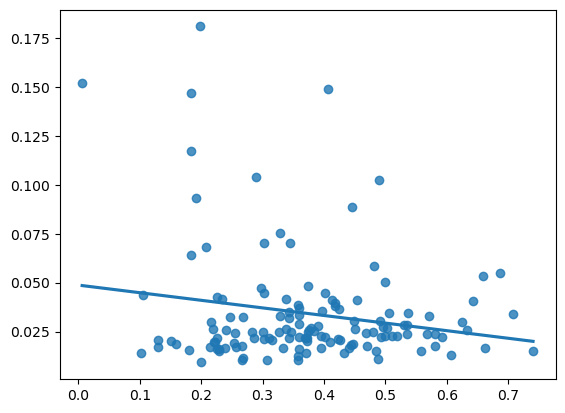

In [11]:
#sns.lineplot(data=cons[(cons['REF_YEAR'] <= 2021) & (cons['CONSOLIDATED_NAME'].apply(lambda x: x in ('Baisley Park')))],
      #      x='REF_YEAR',y='Legitimate_Per_Res',hue='CONSOLIDATED_NAME')
sns.regplot(data=cons, x='Rejected_Pct', y='Legitimate_Per_Res')
plt.savefig('Outputs/Rejected_Pct_vs_Legitimate_Cases.png')

In [585]:
cons[(cons['REF_YEAR'] >= 2020) & (cons['Total_Case_Count']>=20)].sort_values('Rejected_Pct', ascending=False).head(20)

,REF_YEAR,CONSOLIDATED_NAME,BOROUGH_NAME,Total_Case_Count,TOTAL_POP,ELDERLY_POP,PER_RES,Rej_Count,Rejected_Pct,Legitimate_Per_Res
771,2020,Wilson,Manhattan,29,2016.0,563.0,0.014385,27,0.931034,0.000992
789,2020,Wyckoff Gardens,Brooklyn,65,1654.0,425.0,0.039299,55,0.846154,0.006046
423,2020,Mitchel,Bronx,73,3805.0,790.0,0.019185,60,0.821918,0.003417
159,2020,Cypress Hills,Brooklyn,22,3298.0,573.0,0.006671,18,0.818182,0.001213
473,2022,Patterson,Bronx,30,3944.0,700.0,0.007606,23,0.766667,0.001775
411,2020,Melrose,Bronx,90,2592.0,615.0,0.034722,64,0.711111,0.010031
261,2020,Gun Hill,Bronx,30,1403.0,329.0,0.021383,21,0.700000,0.006415
521,2022,Ravenswood,Queens/SI,25,4102.0,1056.0,0.006095,17,0.680000,0.001950
214,2021,Forest,Bronx,95,4273.0,865.0,0.022233,64,0.673684,0.007255
503,2022,Queensbridge North,Queens/SI,24,2895.0,739.0,0.008290,15,0.625000,0.003109


/Users/kyleslugg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kyleslugg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(0.5368125934832131, 1.388331165299331e-20)


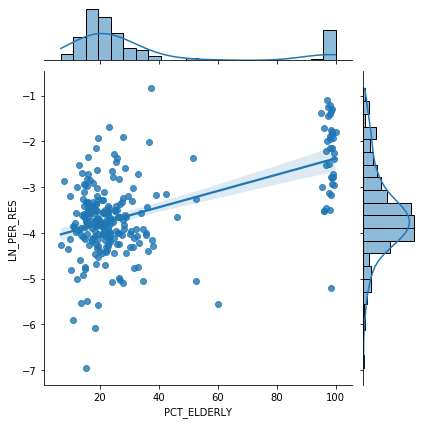

In [531]:
devs_plot = devs[devs['_merge'].apply(lambda x: x != 'right_only')]
devs_plot['PCT_ELDERLY'] = devs_plot['PERCENTAGE_ELDERLY'].astype(float)
#devs_plot = devs_plot[devs_plot['SENIOR_DEV_IND'] == 0]
devs_plot['LN_PER_RES'] = devs_plot['PER_RES'].apply(lambda x: np.log(x))

sns.jointplot(data=devs_plot, kind='reg', x='PCT_ELDERLY', y='LN_PER_RES')
plt.savefig('ns_devs_corr.png')
print(stats.pearsonr(devs_plot['PCT_ELDERLY'], devs_plot['LN_PER_RES']))
#plt.show()

In [418]:
counts = pd.DataFrame(all_nonsenior_recent['NAME'].value_counts()).reset_index()
counts_senior = pd.DataFrame(all_senior_recent['NAME'].value_counts()).reset_index()
counts_all = pd.DataFrame(all_recent['NAME'].value_counts()).reset_index()

repeats_ns = counts[counts['NAME']>2].merge(all_nonsenior_recent[['NAME','Borough','Development']].drop_duplicates(), how='left', right_on='NAME', left_on='index')
repeats_all = counts_all[counts_all['NAME']>2].merge(all_recent[['NAME','Borough','Development']].drop_duplicates(), how='left', right_on='NAME', left_on='index')
repeats_s = counts_senior[counts_senior['NAME']>2].merge(all_senior_recent[['NAME','Borough','Development']].drop_duplicates(), how='left', right_on='NAME', left_on='index')

In [454]:
def repeats_by_dev(repeats_ns):
    dev_repeats_ns = repeats_ns.groupby('Development').agg({'index':'count', 'NAME_x':sum}).sort_values('NAME_x', ascending=False)
    dev_totals_ns = all_nonsenior_recent[['NAME','Development']].groupby('Development').count()

    dev_repeats_ns = dev_repeats_ns.merge(dev_totals_ns, how='left', on='Development')
    dev_repeats_ns.columns = ['Repeats', 'Referrals_from_Repeats', 'Total_Referrals']
    dev_repeats_ns['Pct_by_Repeats'] = dev_repeats_ns['Referrals_from_Repeats']/dev_repeats_ns['Total_Referrals']
    
    return dev_repeats_ns.sort_values('Pct_by_Repeats', ascending=False)

In [519]:
ESAH_sites = list(pd.DataFrame(all_senior_recent[all_senior_recent['Program'] == 'Elderly Safe At Home']['Development'].value_counts()).reset_index()['index'])

/Users/kyleslugg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kyleslugg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/kyleslugg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

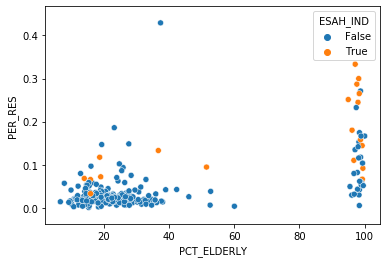

In [532]:
devs_plot = devs[devs['_merge'].apply(lambda x: x != 'right_only')]
devs_plot['PCT_ELDERLY'] = devs_plot['PERCENTAGE_ELDERLY'].astype(float)
#devs_plot = devs_plot[devs_plot['SENIOR_DEV_IND'] == 1]
devs_plot['LN_PER_RES'] = devs_plot['PER_RES'].apply(lambda x: np.log(x))
devs_plot['ESAH_IND'] = devs_plot['Development'].apply(lambda x: x in ESAH_sites)

sns.scatterplot(data=devs_plot, x='PCT_ELDERLY', y='PER_RES', hue='ESAH_IND')

In [614]:
#all_recent = all_recent.merge(pop_facts_enriched, how='left', left_on='_match_dev', right_on='DEVELOPMENT_NAME')
riis=all_recent[all_recent['CONSOLIDATED_NAME'] == 'Riis'].sort_values('Ref_Date', ascending=False)

In [616]:
riis[['Case_ID', 'Development', 'Program', 'Status', 'Ref_Type', 'Ref_Name']].groupby(['Development','Program','Status','Ref_Type']).count()

Case_ID  Ref_Name
Development  Program             Status   Ref_Type                            
RIIS CITY    Clinical Unit       Closed   Management               6         6
             Clinical Unit (Gal) Closed   Law                      3         3
             SOS                 Closed   Management              17        17
                                 Rejected Law                      1         1
                                          Management              16        16
RIIS FEDERAL Clinical Unit       Closed   Director's Office        1         1
                                          Management               8         8
                                 Open     Director's Office        1         1
             Clinical Unit (Gal) Closed   Law                      7         7
             SOS                 Closed   Management              36        36
                                          Self-Referral            1         1
                                 Open     Management               1         1
                                 Rejected Law                      1         1
                                          Management              27        27

In [612]:
bp[['Case_ID', 'Development', 'Program', 'Status', 'Ref_Type', 'Ref_Name']].groupby(['Development','Status','Ref_Type','Ref_Name']).count()

Case_ID  \
Development                 Status   Ref_Type                Ref_Name                       
BAISLEY PARK                Closed   Community/Senior Center QNAdmin2 Setari            1   
                                     Law                     David Schacher             1   
                                                             Rhea O'Gorman              1   
                                     Management              Ayodeji Festus             4   
                                                             Benita Patterson          10   
                                                             Dionne Henry               4   
                                                             Jacqueline Shepherd       23   
                                                             Pamela King                1   
                            Open     Management              Jacqueline Shepherd        1   
                            Rejected Management              Anjannette McCinnis        2   
                                                             Ayodeji Festus             2   
                                                             Benita Patterson           5   
                                                             Dionne Henry               8   
                                                             Jacqueline Shepherd       10   
CONLON-LIHFE TOWERS         Closed   Director's Office       Suzanne Setari             4   
                                     Management              Ayodeji Festus             4   
                                                             Dionne Henry               9   
                                                             Gail Farquharson           1   
                                                             Jacqueline Shepherd        6   
                                                             Pamela King                2   
                                     Resident Leader         QNAdmin2 Setari            1   
                                                             Sameerah Calhoun           4   
                                                             Suzanne Setari             1   
                            Rejected Hearing Officer         Dionne Henry               1   
                                     Management              Ayodeji Festus             2   
                                                             Benita Patterson           1   
                                                             Dionne Henry               4   
                                                             Gail Farquharson           2   
                                                             Jacqueline Shepherd        2   
FHA REPOSSESSED HOUSES GP I Closed   Director's Office       BKAdmin5 Gwyn              2   
                                                             QNAdmin3 Gwyn             80   
                                     Law                     Irene Kambos               1   
                                     Management              Benita Patterson           6   
                                                             Jacqueline Shepherd        2   
                                                             Pamela King                2   
                            Open     Management              Jacqueline Shepherd        1   
INTERNATIONAL TOWER         Closed   Director's Office       Jacqueline Shepherd        1   
                                     Management              Anjannette McCinnis        1   
                                                             Benita Patterson           1   
                                                             Jacqueline Shepherd       20   
                                     Resident Leader         Suzanne Setari             1   
                            Open     Management              Jacqueline Shepherd   

In [534]:
all_recent[all_recent['Development'] == 'ASTORIA'].to_excel('Outputs_TEMP_Astoria.xlsx')

In [537]:
rejected['Development'].value_counts()

PATTERSON                                   727
POMONOK                                     438
BRONX RIVER                                 374
MARBLE HILL                                 372
MILL BROOK                                  317
                                           ... 
131 ST. NICHOLAS AVE                          1
COLLEGE POINT REHAB PROGRAM                   1
RANDOLPH                                      1
AUDUBON APARTMENTS                            1
WEST TREEMONT REHAB. GROUP 2                  1
Name: Development, Length: 249, dtype: int64